# 🔧 SECOM LightGBM 強化版訓練流程


## 🧪 LightGBM 變體比較：原始、校正機率、PCA 降維版本

本段程式碼建立並比較三種 LightGBM 模型：
1. **原始 LightGBM**
2. **機率校正版 Calibrated LightGBM**（使用 Isotonic Regression）
3. **PCA 降維版 LightGBM**（將 PCA 特徵加回原始特徵）

每個模型都會：
- 預測機率分數（`predict_proba`）
- 計算 PR Curve 並選出 F1 Score 最佳的 threshold
- 儲存最佳門檻、Precision、Recall 與 F1 值
- 匯出 `.pkl` 模型檔案供部署或下游使用

#### 🏆 最佳模型：LightGBM_PCA (th=0.5)
🔍 PR AUC 未達標，ROC AUC + Recall 達標 → 選 Precision 最佳 <br>
🔹 PR AUC：0.1599 ｜ ROC AUC：0.7695 ｜ Recall：0.8095

## 數據前處理

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import (classification_report, precision_recall_curve,
                             recall_score, roc_auc_score, auc, f1_score, roc_curve)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import shap
import joblib
import matplotlib.pyplot as plt

# from SECOM_data_process import SecomPreprocessor
import sys
from pathlib import Path
PROJECT_ROOT = Path.cwd().parent.parent  # 根據你的資料夾結構調整
print(PROJECT_ROOT)
sys.path.append(str(PROJECT_ROOT))
from preprocessing.secom_preprocessor import Preprocessor
from preprocessing.balancer import apply_smoteenn

# 讀資料與標籤
raw_data = pd.read_csv('/Users/ching/Documents/SideProject/data/secom/secom.data', delim_whitespace=True, header=None)
labels = pd.read_csv('/Users/ching/Documents/SideProject/data/secom/secom_labels.data', delim_whitespace=True, header=None)
raw_data.columns = [f"sensor_{i+1}" for i in range(raw_data.shape[1])]
X = raw_data.copy()
y = (labels[0] == 1).astype(int)

# 資料切分
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 前處理（含 SMOTE + 清洗）
# pre = SecomPreprocessor(use_smote=True)
pre = Preprocessor()

X_train_proc = pre.fit_transform(X_train)
X_test_proc = pre.transform(X_test)


# 儲存前處理器
joblib.dump(pre, "secom_preprocessor.pkl")

X_train_proc,y_train = apply_smoteenn(X_train_proc, y_train, random_state=42)


/Users/ching/Documents/SideProject/industrial-fault-prediction
▶ Imputing missing values with mean...
▶ Handling outliers using IQR clipping...
▶ Removing near-zero variance features...
✅ Remaining features after variance filter: 590
▶ Removing highly correlated features (Pearson > 0.95)...


/var/folders/zc/bg3g21_j7yq8y2dpzx88kk4w0000gn/T/ipykernel_28700/1592218548.py:24: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  raw_data = pd.read_csv('/Users/ching/Documents/SideProject/data/secom/secom.data', delim_whitespace=True, header=None)
/var/folders/zc/bg3g21_j7yq8y2dpzx88kk4w0000gn/T/ipykernel_28700/1592218548.py:25: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  labels = pd.read_csv('/Users/ching/Documents/SideProject/data/secom/secom_labels.data', delim_whitespace=True, header=None)


✅ Remaining features after correlation filter: 590
▶ Scaling features...


## 🧪 訓練三種 LightGBM 變體模型

## ⚙️ train_lightgbm_variants 函式說明

本函式可一次訓練三種 LightGBM 模型並評估模型表現，提供最佳門檻選擇與模型儲存功能。

---

### 📌 支援三種模型：
1. 🟢 LightGBM（原始）
2. 🔵 Calibrated LightGBM（使用 Isotonic 校正）
3. 🔴 PCA 降維後 LightGBM（結合前 10 主成分）

---

### 🧠 功能說明：
- `use_best_threshold=True`：根據 PR Curve 自動挑選最佳分類門檻（最大化 F1）
- `use_best_threshold=False`：使用固定門檻 0.5
- `save_model=True`：自動儲存三個模型為 `.pkl` 檔案

---

### 🟨 回傳內容：
- `models`：三個模型物件
- `thresholds`：各模型門檻值
- `results`：dict → 每個模型包含：
  - 預測機率 `y_proba`
  - 使用的門檻值 `threshold`
  - Precision、Recall、F1 分數

---

### 🧪 使用方式範例：

```python
models, thresholds, results = train_lightgbm_variants(
    X_train_proc, y_train, X_test_proc, y_test,
    use_best_threshold=True,
    save_model=True
)

In [22]:
def train_lightgbm_variants(X_train_proc, y_train, X_test_proc, y_test, 
                            use_best_threshold=True, save_model=True):
    """
    訓練三種 LightGBM 模型（原始、Calibrated、PCA 降維）

    use_best_threshold=True → 根據 PR Curve 自動找最佳 threshold
    use_best_threshold=False → 固定使用 0.5 當分類門檻

    回傳：
    - models: 各模型物件
    - results: dict[model] = (y_proba, threshold, precision, recall, f1)
    """
    import lightgbm as lgb
    from sklearn.calibration import CalibratedClassifierCV
    from sklearn.decomposition import PCA
    import joblib
    import numpy as np
    from sklearn.metrics import (
        precision_recall_curve, precision_score, recall_score, f1_score
    )

    def find_best_threshold(y_true, y_proba):
        precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
        best_idx = np.argmax(f1_scores)
        return thresholds[best_idx], precision[best_idx], recall[best_idx], f1_scores[best_idx]

    def compute_metrics(y_true, y_proba, threshold):
        y_pred = (y_proba > threshold).astype(int)
        prec = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        return prec, rec, f1

    models, results, thresholds = {}, {}, {}

    # 訓練通用流程（原始、校正、PCA）
    def process_model(name, model, X_test_input):
        y_proba = model.predict_proba(X_test_input)[:, 1]
        if use_best_threshold:
            threshold, prec, rec, f1 = find_best_threshold(y_test, y_proba)
        else:
            threshold = 0.5
            prec, rec, f1 = compute_metrics(y_test, y_proba, threshold)
        models[name] = model
        thresholds[name] = threshold
        results[name] = (y_proba, threshold, prec, rec, f1)
        if save_model:
            joblib.dump(model, f"{name}_model.pkl")

    # 🟢 原始 LightGBM
    model_lgb = lgb.LGBMClassifier(class_weight='balanced', random_state=42)
    model_lgb.fit(X_train_proc, y_train)
    process_model("LightGBM", model_lgb, X_test_proc)

    # 🔵 Calibrated LightGBM
    model_cal = CalibratedClassifierCV(
        estimator=lgb.LGBMClassifier(class_weight='balanced', random_state=42),
        method='isotonic', cv=3
    )
    model_cal.fit(X_train_proc, y_train)
    process_model("LightGBM_Calibrated", model_cal, X_test_proc)

    # 🔴 PCA 降維版 LightGBM
    pca = PCA(n_components=10)
    X_train_pca = np.hstack([X_train_proc, pca.fit_transform(X_train_proc)])
    X_test_pca = np.hstack([X_test_proc, pca.transform(X_test_proc)])
    model_pca = lgb.LGBMClassifier(class_weight='balanced', random_state=42)
    model_pca.fit(X_train_pca, y_train)
    process_model("LightGBM_PCA", model_pca, X_test_pca)

    return models, thresholds, results

## 🎯 模型效能視覺化工具 `plot_lgb_results()`

本函式用於統一評估與視覺化多個二元分類模型的預測結果。

### 功能說明：
- 📋 輸出各模型的 Precision / Recall / F1 / ROC AUC 總表格
- 🔷 畫出每個模型的混淆矩陣與分類報告
- 📈 並列三種評估曲線：
  - Precision-Recall Curve
  - ROC Curve
  - F1 Score vs Threshold

### 輸入參數：
- `results_dict`: 每個模型的 (y_proba, threshold, precision, recall, f1)
- `y_test`: 測試資料的真實標籤
- `model_names`: 可選參數，若只想比對特定模型，可指定模型名稱清單

### 回傳：
- `df_metrics`: 各模型指標總表 (P/R/F1/AUC)

---

### 📌 範例使用：

```python
df_metrics = plot_lgb_results(results_thAuto, y_test)

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import (
    confusion_matrix, classification_report,
    precision_recall_curve, roc_curve, roc_auc_score, auc
)

def plot_lgb_results(results_dict, y_test, model_names=None):
    """
    results_dict: dict[model_name] = (y_proba, threshold, precision, recall, f1)
    y_test: ground truth array
    model_names: 若僅想比較部分模型，可傳入 list
    """

    if model_names is None:
        model_names = list(results_dict.keys())

    print("📊 各模型指標總表：\n")
    all_metrics = []
    for name in model_names:
        y_proba, threshold, prec, rec, f1 = results_dict[name]
        y_pred = (y_proba > threshold).astype(int)
        roc_auc = roc_auc_score(y_test, y_proba)
        all_metrics.append({
            "Model": name,
            "Precision": prec,
            "Recall": rec,
            "F1-Score": f1,
            "ROC AUC": roc_auc
        })

    df_metrics = pd.DataFrame(all_metrics).round(3)
    display(df_metrics)

    # 混淆矩陣與分類報告
    for name in model_names:
        y_proba, threshold, _, _, _ = results_dict[name]
        y_pred = (y_proba > threshold).astype(int)

        cm = confusion_matrix(y_test, y_pred)
        report = classification_report(y_test, y_pred, target_names=["Non-Fault", "Fault"])
        print(f"\n📌 {name} 分類報告：\n{report}")

        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                    xticklabels=["Non-Fault", "Fault"],
                    yticklabels=["Non-Fault", "Fault"])
        plt.title(f"Confusion Matrix - {name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        plt.show()

    # === 三圖併列 ===
    plt.figure(figsize=(18, 5))

    # PR Curve
    plt.subplot(1, 3, 1)
    for name in model_names:
        y_proba, *_ = results_dict[name]
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f"{name} (AUC={pr_auc:.3f})")
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True)
    plt.legend()

    # ROC Curve
    plt.subplot(1, 3, 2)
    for name in model_names:
        y_proba, *_ = results_dict[name]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.title("ROC Curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.grid(True)
    plt.legend()

    # F1 vs Threshold
    plt.subplot(1, 3, 3)
    for name in model_names:
        y_proba, *_ = results_dict[name]
        precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
        plt.plot(thresholds, f1_scores[:-1], label=name)
    plt.title("F1 Score vs Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("F1 Score")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    return df_metrics

## 🧪 固定 Threshold = 0.5 的 LightGBM 模型比較

本區段使用 `train_lightgbm_variants()` 函式訓練三種 LightGBM 變體模型，並指定分類門檻為固定值 `0.5`，進行統一效能比較與視覺化。

### 🔧 模型包含：
- LightGBM（原始）
- LightGBM + Isotonic 校正
- LightGBM + PCA 降維

### 📊 評估內容：
- Precision / Recall / F1 / ROC AUC 統計總表
- 混淆矩陣與分類報告
- PR Curve / ROC Curve / F1 vs Threshold 三圖視覺化

[LightGBM] [Info] Number of positive: 1170, number of negative: 139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70596
[LightGBM] [Info] Number of data points in the train set: 1309, number of used features: 279
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 780, number of negative: 92
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70406
[LightGBM] [Info] Number of data points in the train set: 872, number of used features: 279
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 780, number of negative: 93
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70251
[LightGBM] [Info] Number of data points in the train set: 873, number of used features: 279
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 780, number of negative: 93
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70257
[LightGBM] [Info] Number of data points in the train set: 873, number of used features: 279
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1170, number of negative: 139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 73146
[LightGBM] [Info] Number of data points in the train set: 1309, number of used features: 289
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
📊 各模型指標總表：



/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Model,Precision,Recall,F1-Score,ROC AUC
0,LightGBM,0.123,0.857,0.216,0.722
1,LightGBM_Calibrated,0.090,0.286,0.136,0.701
2,LightGBM_PCA,0.136,0.810,0.233,0.770



📌 LightGBM 分類報告：
              precision    recall  f1-score   support

   Non-Fault       0.98      0.56      0.72       293
       Fault       0.12      0.86      0.22        21

    accuracy                           0.58       314
   macro avg       0.55      0.71      0.47       314
weighted avg       0.92      0.58      0.68       314



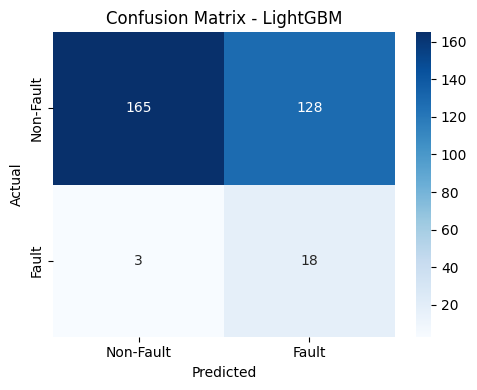


📌 LightGBM_Calibrated 分類報告：
              precision    recall  f1-score   support

   Non-Fault       0.94      0.79      0.86       293
       Fault       0.09      0.29      0.14        21

    accuracy                           0.76       314
   macro avg       0.51      0.54      0.50       314
weighted avg       0.88      0.76      0.81       314



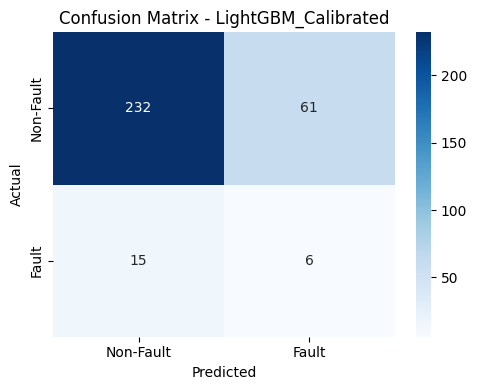


📌 LightGBM_PCA 分類報告：
              precision    recall  f1-score   support

   Non-Fault       0.98      0.63      0.77       293
       Fault       0.14      0.81      0.23        21

    accuracy                           0.64       314
   macro avg       0.56      0.72      0.50       314
weighted avg       0.92      0.64      0.73       314



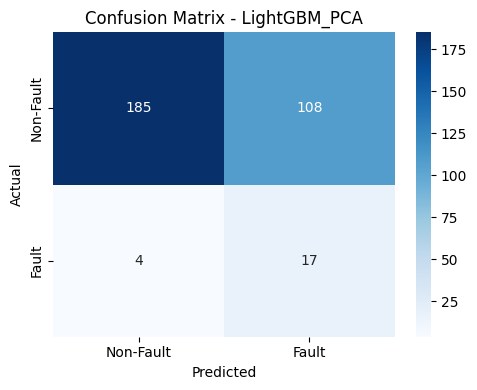

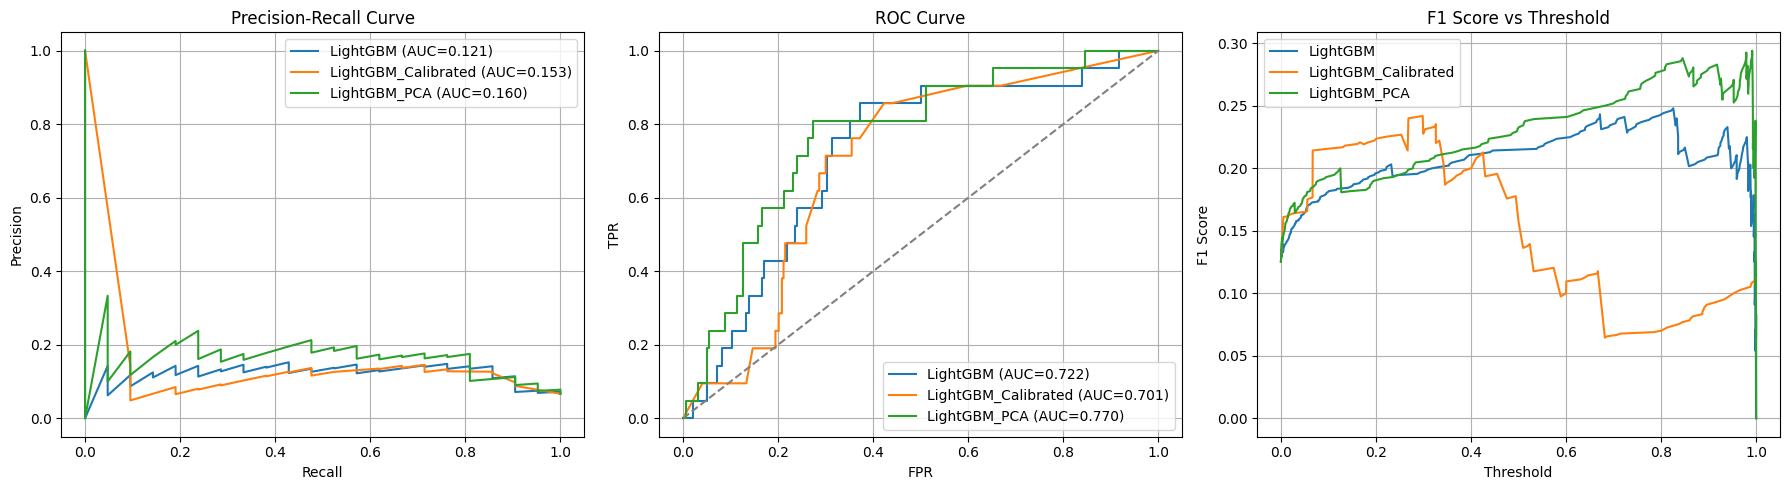

In [24]:

# 用固定 threshold 0.5
models_th05, thresholds_th05, results_th05 = train_lightgbm_variants(
    X_train_proc, y_train, X_test_proc, y_test,
    use_best_threshold=False
)

df_metrics_th05 = plot_lgb_results(results_th05, y_test)

## 🧪 使用最佳 Threshold 的 LightGBM 模型比較

本區段將透過 `train_lightgbm_variants()` 函式啟用 `use_best_threshold=True` 模式，根據 PR Curve 自動選出最大 F1 對應的分類門檻，進行三種 LightGBM 模型的效能優化與比較。

### ✅ 模型清單：
- LightGBM（原始）
- LightGBM + Isotonic 校正
- LightGBM + PCA 降維

### 🔍 門檻設定邏輯：
- 使用 Precision-Recall 曲線自動選出最佳門檻
- 目標為最大化 F1 Score

### 📊 評估內容：
- 精確率、召回率、F1 分數、ROC AUC 指標
- 混淆矩陣 + 分類報告
- 三圖併列：PR Curve、ROC Curve、F1 vs Threshold

[LightGBM] [Info] Number of positive: 1170, number of negative: 139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70596
[LightGBM] [Info] Number of data points in the train set: 1309, number of used features: 279
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 780, number of negative: 92
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70406
[LightGBM] [Info] Number of data points in the train set: 872, number of used features: 279
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 780, number of negative: 93
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70251
[LightGBM] [Info] Number of data points in the train set: 873, number of used features: 279
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 780, number of negative: 93
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70257
[LightGBM] [Info] Number of data points in the train set: 873, number of used features: 279
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1170, number of negative: 139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 73146
[LightGBM] [Info] Number of data points in the train set: 1309, number of used features: 289
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
📊 各模型指標總表：



/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Model,Precision,Recall,F1-Score,ROC AUC
0,LightGBM,0.148,0.762,0.248,0.722
1,LightGBM_Calibrated,0.146,0.714,0.242,0.701
2,LightGBM_PCA,0.273,0.429,0.333,0.746



📌 LightGBM 分類報告：
              precision    recall  f1-score   support

   Non-Fault       0.97      0.69      0.80       293
       Fault       0.14      0.71      0.23        21

    accuracy                           0.69       314
   macro avg       0.56      0.70      0.52       314
weighted avg       0.92      0.69      0.77       314



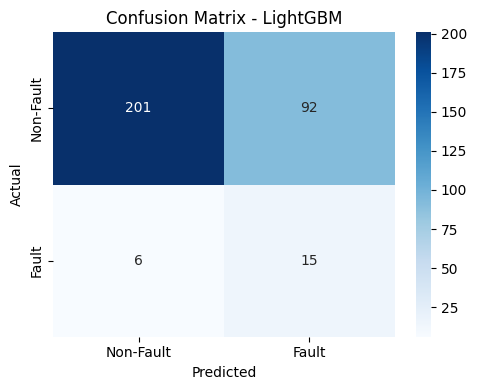


📌 LightGBM_Calibrated 分類報告：
              precision    recall  f1-score   support

   Non-Fault       0.97      0.70      0.81       293
       Fault       0.14      0.67      0.23        21

    accuracy                           0.70       314
   macro avg       0.55      0.68      0.52       314
weighted avg       0.91      0.70      0.77       314



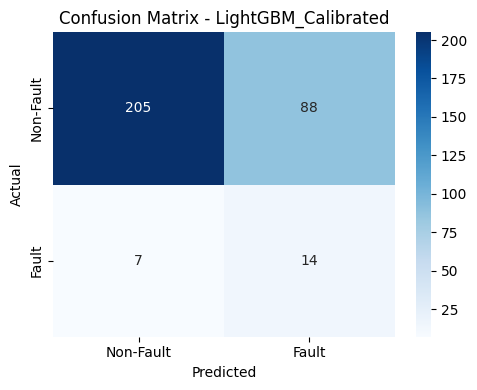


📌 LightGBM_PCA 分類報告：
              precision    recall  f1-score   support

   Non-Fault       0.95      0.92      0.94       293
       Fault       0.25      0.38      0.30        21

    accuracy                           0.88       314
   macro avg       0.60      0.65      0.62       314
weighted avg       0.91      0.88      0.89       314



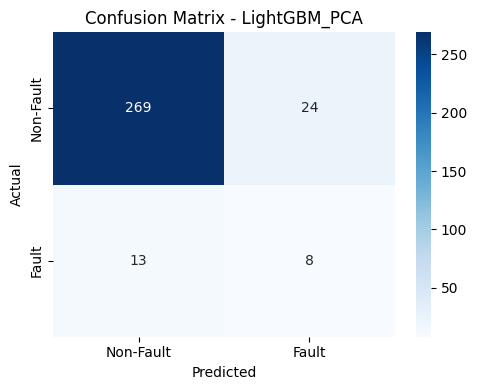

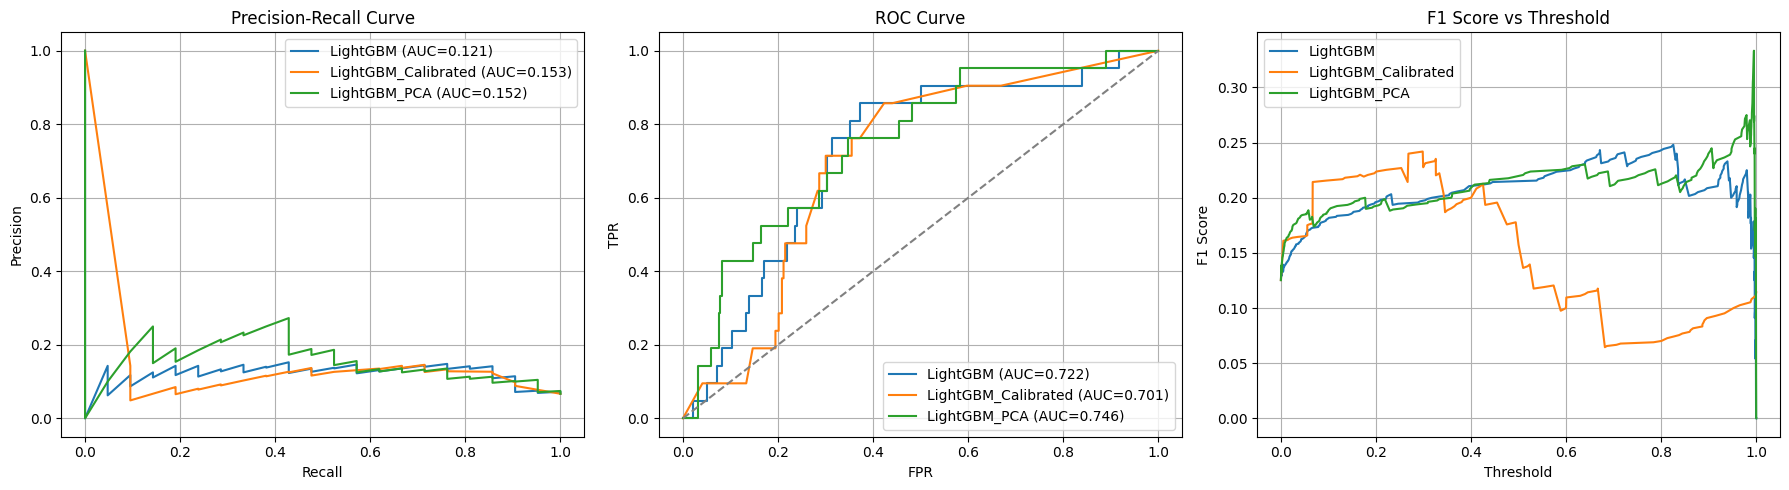

In [25]:
# 用最佳 threshold（動態決定）
models_thAuto, thresholds_thAuto, results_thAuto = train_lightgbm_variants(
    X_train_proc, y_train, X_test_proc, y_test,
    use_best_threshold=True
)

df_metrics_thAuto = plot_lgb_results(results_thAuto, y_test)


## 🏁 模型效能比較與最佳模型選擇：`select_best_model_combined()`

此函式可整合不同來源（如固定 threshold vs 最佳 threshold）模型的評估結果，並依據多重條件選出最佳模型。

---

### 📥 輸入說明：

- `results_dicts`: dict 結構，如：
  ```python
  {
    "threshold=0.5": results_th05,
    "best_threshold": results_thAuto
  }

In [28]:
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, auc, recall_score
)

def select_best_model_combined(results_dicts, y_test, pr_auc_thresh=0.6, roc_auc_thresh=0.7, recall_thresh=0.8):
    all_scores = {}

    for source_name, results in results_dicts.items():
        for name, (y_proba, threshold, prec, rec, f1) in results.items():
            model_id = f"{name} ({source_name})"
            pr, rc, _ = precision_recall_curve(y_test, y_proba)
            pr_auc = auc(rc, pr)
            roc_auc = roc_auc_score(y_test, y_proba)
            y_pred = (y_proba > threshold).astype(int)
            rec_check = recall_score(y_test, y_pred)

            all_scores[model_id] = {
                "Model": model_id,
                "Precision": prec,
                "Recall": rec_check,
                "F1-Score": f1,
                "PR AUC": pr_auc,
                "ROC AUC": roc_auc,
                "Source": source_name
            }

    df_all = pd.DataFrame.from_dict(all_scores, orient="index")

    # 選擇邏輯
    qualified = df_all[
        (df_all["PR AUC"] >= pr_auc_thresh) &
        (df_all["ROC AUC"] >= roc_auc_thresh)
    ]

    if not qualified.empty:
        best = qualified.sort_values("Recall", ascending=False).iloc[0]
        reason = "🎯 PR AUC + ROC AUC 達標，選 Recall 最佳"
    else:
        qualified = df_all[
            (df_all["ROC AUC"] >= roc_auc_thresh) &
            (df_all["Recall"] >= recall_thresh)
        ]
        if not qualified.empty:
            best = qualified.sort_values("Precision", ascending=False).iloc[0]
            reason = "🔍 PR AUC 未達標，ROC AUC + Recall 達標 → 選 Precision 最佳"
        else:
            best = df_all.sort_values("Recall", ascending=False).iloc[0]
            reason = "⚠️ 僅選 Recall 最佳"

    print(f"\n🏆 最佳模型：{best['Model']}")
    print(f"{reason}")
    print(f"🔹 PR AUC：{best['PR AUC']:.4f} ｜ ROC AUC：{best['ROC AUC']:.4f} ｜ Recall：{best['Recall']:.4f}")

    return df_all, best

In [29]:
# 合併兩組結果（固定 vs 最佳 threshold）
results_dicts = {
    "th=0.5": results_th05,
    "auto-th": results_thAuto
}

df_all_results, best_model_info = select_best_model_combined(results_dicts, y_test)


🏆 最佳模型：LightGBM_PCA (th=0.5)
🔍 PR AUC 未達標，ROC AUC + Recall 達標 → 選 Precision 最佳
🔹 PR AUC：0.1599 ｜ ROC AUC：0.7695 ｜ Recall：0.8095


## 📊 模型指標視覺化比較圖（Bar Chart）

本區段使用 `plot_model_comparison_bar()` 函式，統一比較所有模型在以下五項指標的表現：

- **F1-Score**
- **Recall**
- **Precision**
- **PR AUC**
- **ROC AUC**

資料來源包含兩組模型訓練策略：

1. `threshold=0.5`：固定門檻的傳統分類結果
2. `best_threshold`：根據 PR Curve 自動選出的最佳分類門檻

---

### 📌 圖表說明：
- 每一張圖皆橫向顯示各模型對應指標的表現
- 同一模型若來自不同策略，會以顏色區分（例如 LightGBM (threshold=0.5) vs LightGBM (best_threshold)）
- 有助於判斷：
  - 是否使用最佳 threshold 能提升模型效能？
  - 哪種 LightGBM 變體在各指標最穩定？

---

### 🧪 執行方式：

```python
plot_model_comparison_bar(df_all)

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_model_comparison_bar(df_all, metrics=["F1-Score", "Recall", "Precision", "PR AUC", "ROC AUC"]):
    """
    df_all: 所有模型評估指標（來自 select_best_model_combined 回傳）
    metrics: 要視覺化的指標列表
    """
    plt.figure(figsize=(12, len(metrics) * 4))
    sns.set(style="whitegrid")

    for i, metric in enumerate(metrics, 1):
        plt.subplot(len(metrics), 1, i)
        sorted_df = df_all.sort_values(metric, ascending=False)
        sns.barplot(x=metric, y="Model", data=sorted_df, hue="Source", dodge=False)
        plt.title(f"{metric} Comparison")
        plt.xlabel(metric)
        plt.ylabel("Model")
        plt.xlim(0, 1)
        plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()


🏆 最佳模型：LightGBM_PCA (threshold=0.5)
🔍 PR AUC 未達標，ROC AUC + Recall 達標 → 選 Precision 最佳
🔹 PR AUC：0.1599 ｜ ROC AUC：0.7695 ｜ Recall：0.8095


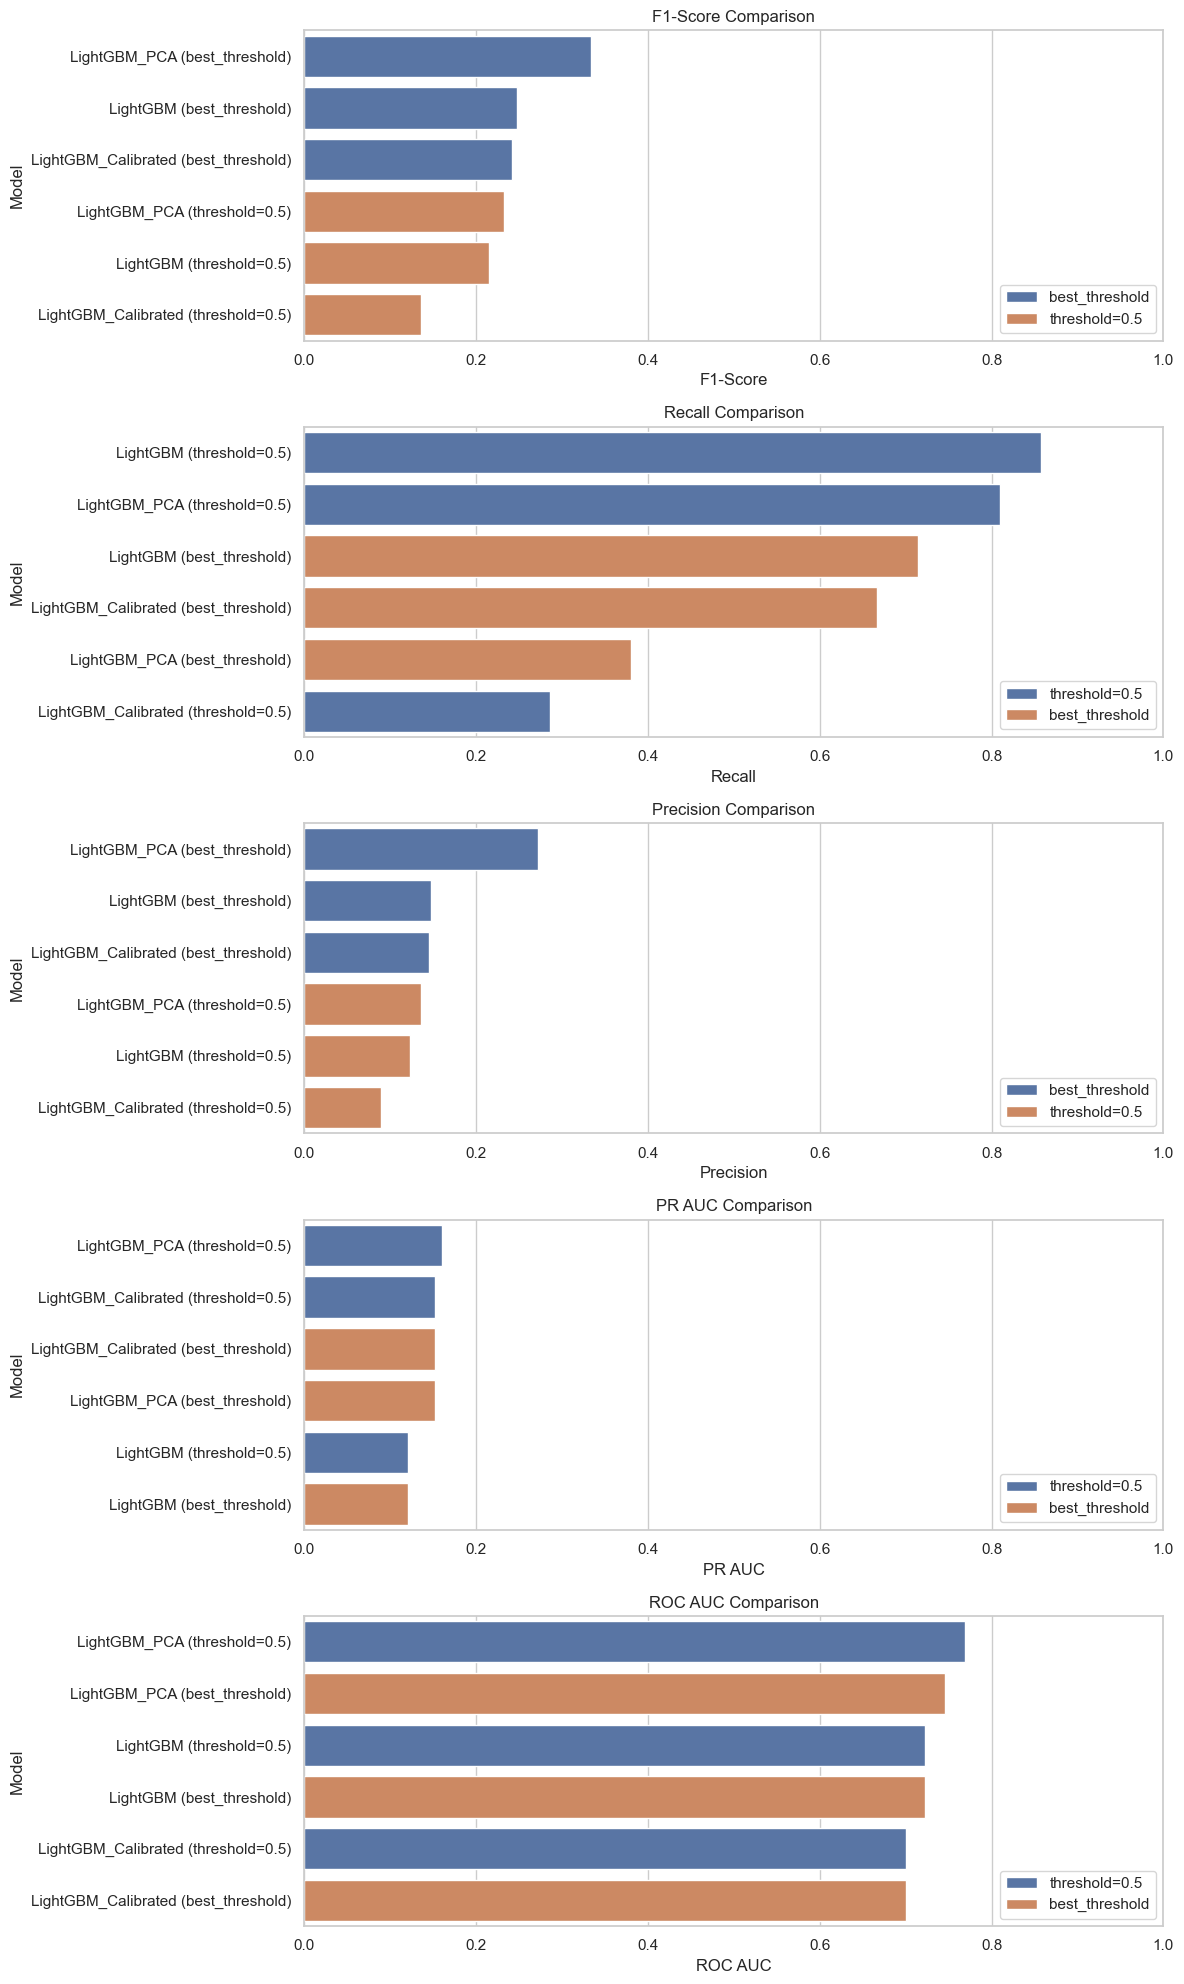

In [31]:
# 比較所有模型效能
df_all, best_model = select_best_model_combined(
    results_dicts={
        "threshold=0.5": results_th05,
        "best_threshold": results_thAuto
    },
    y_test=y_test
)

# 畫圖比較
plot_model_comparison_bar(df_all)